In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load the train data
cambia e fai load su cartella 2020


In [3]:
train_data = pd.read_csv('/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/train_data.csv', encoding="utf8")

In [4]:
train_data.head()
#shape(train_data)

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [5]:
train_data.author.unique().shape
#train_data.subreddit.unique().shape


(5000,)

di nuovo come sopra

In [6]:
target = pd.read_csv('/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/train_target.csv')

In [7]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


**Estraggo anche test set, mi serve per migliorare count vectorizer e tfidftransform()**

In [8]:
test_data = pd.read_csv("/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/test_data.csv", encoding="utf8")

In [9]:
test_data.body = test_data['body'].apply(str)

**Definisco funzione per estrazione testo da pandas dataframe**

In [10]:
def extract_text(group):
    group_text = group['body'].values
    return " ".join(group_text)

extract_text(train_data[train_data.author=='RedThunder90'])
#extract_text(train_data[train_data.subreddit=='sex'])

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

**Creo dizionario con authori e testo del train set**

In [11]:
# creo dizionario con 'keys'=author e valori = a quello che ha scritto l'autore

text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

    
len(text_dict)

5000

In [12]:
author_text = [text_dict[author] for author in target.author]
len(author_text)

5000

**Creo dizionario con autori e testo del test set**

In [13]:
text_dict_test = {}

for author, group in test_data.groupby('author'):
    text_dict_test[author] = extract_text(group)
    
len(text_dict_test)

15000

In [14]:
author_text_test = [text_dict_test[author] for author in test_data.author.unique()]
len(author_text_test)

15000

**Metto insieme ai dati di train**


In [15]:
author_text_total = author_text + author_text_test
len(author_text_total)

20000

**Vettorizzo i commenti contando quante volte ogni autore usa una determinata parola e poi trasformo con tfidf**

In [16]:
# estraggo il testo e lo converto in una matrice sparsa Xij 
# con i autore e j "feature" ovvero le parole usate nel suo testo che non fanno parte della lista stop_words.
# N.B: posso usare come feature anche coppie di parole consecutive cambiando in ngram_range(1,2)
# o entrambe (sia singole che coppie) usando ngram_range(0,2)

from sklearn.feature_extraction import text

vectorizer = text.CountVectorizer(max_df = 0.95, min_df = 0.01, stop_words = 'english')
C = vectorizer.fit_transform(author_text_total)
tfidf = text.TfidfTransformer().fit_transform(C)

In [17]:
tfidf = tfidf.toarray()
print('SHAPE&TYPE TFIDF:', shape(tfidf),' || ', type(tfidf))

SHAPE&TYPE TFIDF: (20000, 7118)  ||  <class 'numpy.ndarray'>


**Prendo come train set i primi 5000 tfidf**

In [18]:
tfidf_train = tfidf[:5000]

**Ricavo dati target**

In [19]:
y = target.gender
print(type(y),' ', shape(y))

<class 'pandas.core.series.Series'>   (5000,)


# Model Selection - TFIDF

**Divido in set di train e di validation**

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_train, y, test_size=.2, random_state = 32)

**Creo dizionario di modelli da utilizzare e stampo i risultati sul train set tfidf**

In [21]:
#importo i modelli
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict

# creo dizionario dei modelli di classificazione
# Multinomial Naive Bayes non funziona perchè dopo la PCA i dati possono assumere valori negativi (in X hanno valore 0 o 1 a seconda che l'autore abbia o no partecipato al subreddit)
#PERCHé assumono vaori anche negativi? perchè sono nuove features combo lineari degli 0 e 1?
models = OrderedDict([
          ('Knn 5', KNeighborsClassifier(4)),
          ('Gaussian Naive Bayes', GaussianNB()),
          ('Multinomial Naive Bayes', MultinomialNB()),
          ('Logistic Regression', LogisticRegression(solver='liblinear')), #uso liblinear, mlto efficiente su large and sparse datasets
          #('Linear SVM', SVC(kernel='linear', probability=True)),
          #('Poly SVM', SVC(kernel='poly', degree=2, probability=True)),
          #('RBF SVM', SVC(kernel='rbf', gamma=2, C=1, probability=True)),
          ('Classification Tree', DecisionTreeClassifier(max_depth=5)),
          ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=100)),
          ('Multilayer Perceptron', MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=5000,
                                                  learning_rate='invscaling', random_state=0))
          ])

In [22]:
best_score=.0
best_name=' '

for name in models:
    clf = models[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score>best_score:
        best_score=score
        best_name=name
    print(name, score)
    
print('\nBest model is ', best_name, 'with a score = ', best_score)

Knn 5 0.752
Gaussian Naive Bayes 0.744
Multinomial Naive Bayes 0.797
Logistic Regression 0.83
Classification Tree 0.772
Random Forest 0.75
Multilayer Perceptron 0.822

Best model is  Logistic Regression with a score =  0.83


## Logistic Regression - TFIDF

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]

Best C: 1.0

Best score: 0.83 



Text(0, 0.5, 'Score (accuracy)')

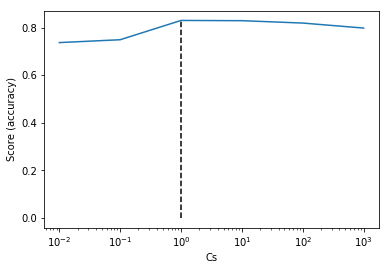

In [23]:
creg=logspace(-2,3,6)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

semilogx(creg, scores)
plt.vlines(creg[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Cs')
plt.ylabel('Score (accuracy)')

**Raffino la ricerca su best-C for logreg**

In [24]:
a=log10(bestcreg)
print(a)

creg=logspace(a-1,a+1,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

0.0
[ 0.1         0.31622777  1.          3.16227766 10.        ]

Best C: 3.1622776601683795

Best score: 0.832 



**Raffino ancora**

In [25]:
creg=logspace(0,1,10)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

[ 1.          1.29154967  1.66810054  2.15443469  2.7825594   3.59381366
  4.64158883  5.9948425   7.74263683 10.        ]

Best C: 5.994842503189409

Best score: 0.836 



## MLP - TFIDF

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]

Best Alpha: 0.1

Best score: 0.824 

Scores:  [0.822, 0.819, 0.823, 0.824, 0.737, 0.737, 0.263, 0.263, 0.263, 0.263]


Text(0, 0.5, 'Score (accuracy)')

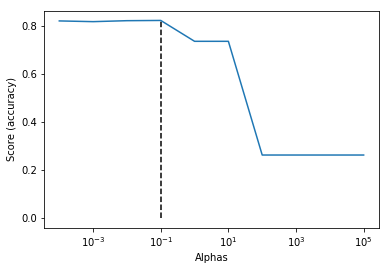

In [26]:
alphas=logspace(-4,5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=5000,
                                                  learning_rate='invscaling', random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ',scores)


semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

**Raffino la ricerca sul parametro d'ottimizzazione alpha**

[0.01       0.03162278 0.1        0.31622777 1.        ]

Best Alpha: 0.31622776601683794

Best score: 0.829 

Scores:  [0.817, 0.825, 0.823, 0.829, 0.817]


Text(0, 0.5, 'Score (accuracy)')

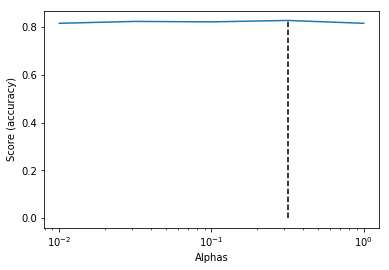

In [27]:
a=log10(bestalpha)

alphas=logspace(a-1,a+1,5)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

## MultinomialNayveBayes - TFIDF

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]

Best Alfa: 0.01

Best score: 0.821 

Scores:  [0.821, 0.819, 0.797, 0.737, 0.737]


Text(0, 0.5, 'Score (accuracy)')

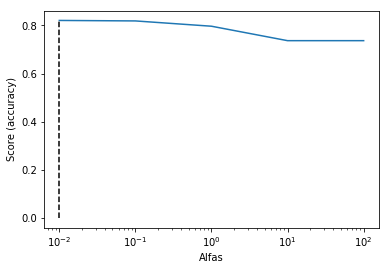

In [28]:
alfas=logspace(-2,2,5)

scores=[]
print (alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

**Raffino ancora**

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]

Best Alfa: 0.0001

Best score: 0.822 

Scores:  [0.822, 0.822, 0.821, 0.819, 0.797]


Text(0, 0.5, 'Score (accuracy)')

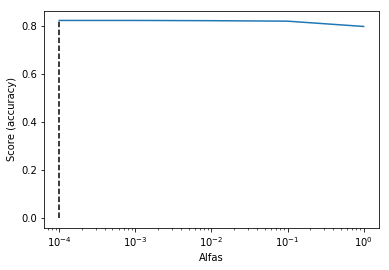

In [29]:
a = log10(bestalfa)

alfas=logspace(a-2,a+2,5)

scores=[]
print (alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

## CALCOLO LE PREDICTED PROBA DEI 3 MODELLI PER TFIDF

**Uso tutto il dataset per allenare la migliroe logistic, mlp e naive bayes e calcolo le predicted proba dei tre modelli**

In [30]:
LogReg = LogisticRegression(solver='liblinear', C=bestcreg).fit(tfidf_train,y)
MLP = MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=bestalpha).fit(tfidf_train,y)
MNB = MultinomialNB(alpha=bestalfa).fit(tfidf_train,y)

#prendo solo la seconda colonna, quella che indica la probabilità che author sia donna
proba1 = LogReg.predict_proba(tfidf_train)[:,1]
proba2 = MLP.predict_proba(tfidf_train)[:,1]
proba3 = MNB.predict_proba(tfidf_train)[:,1]

#trasformo in matrici autori x predictedproba
Proba1 = reshape(proba1,(5000,1))
Proba2 = reshape(proba2,(5000,1))
Proba3 = reshape(proba3,(5000,1))

#creo un'unica matrice di dati
PTOT = hstack([Proba1,Proba2,Proba3])

In [31]:
shape(PTOT)

(5000, 3)

## Logistic Regression on predict_proba from 3 models - TFIDF

In [32]:
X_train, X_test, y_train, y_test = train_test_split(PTOT, y, test_size=.2, random_state = 32)

In [33]:
Cs=logspace(-3,6,10)
scores=[]

for c in Cs:
    LRTOT=LogisticRegression(solver='liblinear', C=c).fit(X_train,y_train)
    score=LRTOT.score(X_test, y_test)
    scores.append(score)
    print('Score = ', score,' C= ', c)
    
best_c = Cs[np.argmax(scores)]
print('BEST C IS: ', best_c)

Score =  0.789  C=  0.001
Score =  0.936  C=  0.01
Score =  0.959  C=  0.1
Score =  0.976  C=  1.0
Score =  0.978  C=  10.0
Score =  0.977  C=  100.0
Score =  0.977  C=  1000.0
Score =  0.977  C=  10000.0
Score =  0.977  C=  100000.0
Score =  0.977  C=  1000000.0
BEST C IS:  10.0


In [34]:
LR=LogisticRegression(solver='liblinear', C=best_c).fit(PTOT,y)
predictions_output = LR.predict_proba(PTOT)[:,1]
TFIDF=reshape(predictions_output,(5000,1))
shape(TFIDF)

(5000, 1)

# Export train data to csv
**Esporto le predicted proba del modello finale sul train set da usare in MERGINGDATA.ipynb**

In [37]:
TFIDF_train_output = pd.DataFrame({"author":train_data.author.unique(), "TFIDF":predictions_output})
#TFIDF_train_output.head()
TFIDF_train_output.tail()

,author,TFIDF
4995,BrennanDobak,0.001651
4996,J_Mallory,0.998324
4997,MasonJarTeaDrinker,0.012827
4998,Thegirlonfire5,0.995905
4999,emptyRR,0.002230


In [38]:
TFIDF_train_output.to_csv("TFIDF_train_output.csv", index=False)

# Prepare the solution

**Riprendo i dati di test gia vettorizzati in tfidf prima**

In [71]:
tfidf_test = tfidf[5000:]
len(tfidf_test)

15000

In [72]:
prob1=LogReg.predict_proba(tfidf_test)[:,1]
prob2=MLP.predict_proba(tfidf_test)[:,1]
prob3=MNB.predict_proba(tfidf_test)[:,1]

Prob1=reshape(prob1,(15000,1))
Prob2=reshape(prob2,(15000,1))
Prob3=reshape(prob3,(15000,1))
shape(Prob1)

(15000, 1)

In [73]:
XTOT = hstack([Prob1,Prob2,Prob3])
shape(XTOT)

(15000, 3)

In [78]:
y_pred = LR.predict_proba(XTOT)[:,1]

In [79]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head()

,author,gender
0,ejchristian86,0.999932
1,ZenDragon,0.002011
2,savoytruffle,0.001946
3,hentercenter,0.206546
4,rick-o-suave,0.029035


In [81]:
solution.tail()

,author,gender
14995,oneblazeofglory,0.999891
14996,prettydamnquick,0.000512
14997,The-Rtnb-Ab-Traxv,0.012098
14998,TheGrandRebel,0.023987
14999,C-BASS,0.006664


In [82]:
solution.to_csv("solutionTFIDF.csv", index=False)

In [83]:
%%sh
head solutionTFIDF.csv

author,gender
ejchristian86,0.9999320588725689
ZenDragon,0.002010673194149476
savoytruffle,0.0019464370536465424
hentercenter,0.2065456481046098
rick-o-suave,0.029035077482621154
olivermihoff,0.7920543638236173
Cleriesse,0.9986529525595649
murderer_of_death,0.0009280359608915621
SpiralSoul,0.07819362420009271
